In [129]:
import numpy as np
np.set_printoptions(precision=4,suppress=True)
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from math import pi
from numpy import linalg as LA

In [2]:
sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
sigmaz = np.array([[1,0],[0,-1]])
sigmap = np.array([[0,1],[0,0]])
sigmam = np.array([[0,0],[1,0]])

def String(num_string):
    SOP = 1
    for ns, sid in enumerate(num_string):
        if sid == 0:
            OP = np.eye(2)
        elif sid==1:
            OP = sigmax
        elif sid==2:
            OP = sigmay
        elif sid==3:
            OP = sigmaz
        elif sid == 4:
            OP = sigmam
        elif sid == 5:
            OP = sigmap
        else:
            pass
        SOP = np.kron(OP,SOP)
    return SOP

def qtoclabel(num_string):
    stat_num = 0
    for ns, sid in enumerate(num_string):
        stat_num = stat_num + sid*(2**ns)
    return stat_num

def qubit_state(Num,ind):
    t0 = ind
    d = np.zeros(Num)
    for n in range(Num-1,0,-1):
        d[n] = int_(np.floor(t0/(2**n)))
        t0 = t0 - d[n]*2**n
    d[0] = np.remainder(ind,2)
    return d

In [3]:
### single-exciation terms are represented by an array with two elements with the first one denoting creation operaotr localtion
### and the second one for the annihilation location
def generate_Pstring(array,N):
    if array[0]!=array[1]:
        M = np.zeros([1,N],dtype=int)
        M[0,array[0]] = 4
        M[0,array[1]] = 5
        for n in range(np.min(array)+1,np.max(array),1):
            M[0,n] = 3
        sgn = np.array([1])
    else:
        M = np.zeros((2,N),dtype=int)
        M[1,array[0]]=3
        sgn = np.array([1/2,-1/2])
    return M, sgn

def generate_matrix_from_CA(array,N):
    ## here the even index of array is for the location of creation operator, and odd index for the annihilation operator
    L = len(array)
    Ne = int(L/2) # number of exciations
    ### get Pauli string arrays
    Pstr=[]
    Sgn_arr = []
    for n in range(Ne):
        A, B = generate_Pstring(np.array([array[2*n],array[2*n+1]]),N)
        Pstr.append(A)
        Sgn_arr.append(B)
    H1e = np.eye(2**N,2**N);
    for n in range(Ne):
        A = np.zeros((2**N,2**N),dtype=complex)
        for n1 in range(len(Sgn_arr[n])):
            A = A + String(Pstr[n][n1,:])*Sgn_arr[n][n1]
        H1e = np.dot(H1e,A)
    return H1e

In [4]:
def get_Ham_int(t,U,kx,ky,array,N):
    Hop = np.zeros((2**N,2**N),dtype=complex)
    coef = np.array([-t,-t,-t*np.cos(3*kx),1j*t*np.sin(3*kx),-t,-t,-t*np.cos(3*kx),-1j*t*np.sin(3*kx), \
                     -2*t*np.cos(ky),-2*t*np.cos(ky+2*pi/3),-2*t*np.cos(ky+4*pi/3)])
    for n in range(len(coef)):
        Hop = Hop + generate_matrix_from_CA(array[n,:],N)*coef[n]
    on1 = (String(np.array([0,0,0])) - String(np.array([3,0,0])))/2
    on2 = (String(np.array([0,0,0])) - String(np.array([0,3,0])))/2
    Hint = U*np.dot(on1,on2)
    Htot = Hop + Hint
    return Htot

def get_Ham_HFint(t,U,kx,ky,arrayon,N):
    Hop = np.zeros((2**N,2**N),dtype=complex)
    coef = np.array([-2*t*np.cos(ky),-2*t*np.cos(ky+2*pi/3),-2*t*np.cos(ky+4*pi/3)])
    for n in range(len(coef)):
        Hop = Hop + generate_matrix_from_CA(arrayon[n,:],N)*coef[n]
    on1 = (String(np.array([0,0,0])) - String(np.array([3,0,0])))/2
    on2 = (String(np.array([0,0,0])) - String(np.array([0,3,0])))/2
    Hint = U*np.dot(on1,on2)
    Htot = Hop + Hint
    return Htot

def find_min_half(psi,Eng):
    on1 = (String(np.array([0,0,0])) - String(np.array([3,0,0])))/2
    on2 = (String(np.array([0,0,0])) - String(np.array([0,3,0])))/2
    on3 = (String(np.array([0,0,0])) - String(np.array([0,0,3])))/2
    half_state = np.array([],dtype=int)
    for n in range(len(Eng)):
        if np.allclose(np.dot(psi[:,n].conj().T,np.dot(on1+on2+on3,psi[:,n])),2):
            half_state = np.append(half_state,int(n))
    return half_state

def find_min_HF(Htot,N):
    state_list = np.array([],dtype=int)
    for n1 in range(N):
        for n2 in range(n1,N,1):
            if n1!=n2:
                state = np.zeros(N,dtype=int)
                state[n1]=1
                state[n2]=1
                if len(state_list)==0:
                    state_list = state
                else:
                    state_list = np.vstack((state_list,state))
            else:
                pass
    E_HF = np.array([])
    for n in range(state_list.shape[0]):
        Vstate = Mstate(state_list[n,:])
        E_HF = np.append(E_HF,np.real(np.dot(Vstate.conj().T,np.dot(Htot,Vstate)))[0,0])
    ind = np.argmin(E_HF)
    return state_list[ind,:], E_HF[ind]

In [5]:
def commutator(arr1,arr2):
    n = arr1[0]
    m = arr1[1]
    k = arr2[0]
    l = arr2[1]
    if n==m and m==k and k==l:
        return np.array([[]]), np.array([0])
    elif n==m and m==k and k!=l:
        return np.array([[n,l]]), np.array([1])
    elif n==m and m==l and l!=k:
        return np.array([[k,m]]), np.array([-1])
    elif n==k and k==l and n!=m:
        return np.array([[k,m]]), np.array([-1])
    elif m==k and k==l and n!=m:
        return np.array([[n,l]]), np.array([1])
    elif n==m and k==l and n!=k:
        return np.array([[]]), np.array([0])
    elif n==k and m==l and n!=m:
        return np.array([[]]), np.array([0])
    elif n==l and k==m and n!=k:
        return np.array([[n,n],[m,m]]), np.array([1,-1])
    elif n==m and m!=k and m!=l and k!=l:
        return np.array([[]]), np.array([0])
    elif n==k and n!=m and n!=l and m!=l:
        return np.array([[]]), np.array([0])
    elif n==l and n!=m and n!=k and m!=k:
        return np.array([[k,m]]), np.array([-1])
    elif m==k and m!=n and m!=l and n!=l:
        return np.array([[n,l]]), np.array([1])
    elif m==l and m!=n and m!=k and n!=k:
        return np.array([[]]), np.array([0])
    elif k==l and m!=l and n!=l and n!=m:
        return np.array([[]]), np.array([0])
    else:
        return np.array([[]]), np.array([0])

In [6]:
def get_commutator(Str1,Str2,N):
    L1 = len(Str1)
    Ne1 = int(L1/2) # number of exciations for the first string
    L2 = len(Str2)
    Ne2 = int(L2/2) # number of exciations for the first string
    ##### we focus on the case with at most two-excitations
    Mout = np.zeros((2**N,2**N),dtype=complex)
    if Ne1==1 and Ne2==1:
        M, sgn = commutator(Str1,Str2)
        Nout = len(sgn)
        for n in range(Nout):
            if sgn[0] != 0:
                CAM = generate_matrix_from_CA(M[n,:],N)
                Mout = Mout + CAM*sgn[n]
            else:
                pass
    elif Ne1==1 and Ne2==2:
        M1, sgn1 = commutator(Str1,Str2[0:2])
        M2, sgn2 = commutator(Str1,Str2[2:4])
        for n in range(len(sgn1)):
            if sgn1[n] != 0:
#                 print(M1[n,:],n)
#                 print(sgn1[n])
                CAM0 = generate_matrix_from_CA(M1[n,:],N)
                CAM1 = generate_matrix_from_CA(Str2[2:4],N)
                Mout = Mout + np.dot(CAM0,CAM1)*sgn1[n]
            else:
                pass
        for n in range(len(sgn2)):
            if sgn2[n] != 0:
#                 print(M2[n,:],n)
#                 print(sgn2[n])
                CAM0 = generate_matrix_from_CA(Str2[0:2],N)
                CAM1 = generate_matrix_from_CA(M2[n,:],N)
                Mout = Mout + np.dot(CAM0,CAM1)*sgn2[n]
            else:
                pass
    elif Ne1==2 and Ne2==1:
        M1, sgn1 = commutator(Str1[0:2],Str2)
        M2, sgn2 = commutator(Str1[2:4],Str2)
        for n in range(len(sgn1)):
            if sgn1[n] !=0:
                CAM0 = generate_matrix_from_CA(M1[n,:],N)
                CAM1 = generate_matrix_from_CA(Str1[2:4],N)
                Mout = Mout + np.dot(CAM0,CAM1)*sgn1[n]
            else:
                pass
        for n in range(len(sgn2)):
            if sgn2[n] !=0:
                CAM0 = generate_matrix_from_CA(Str1[0:2],N)
                CAM1 = generate_matrix_from_CA(M2[n,:],N)
                Mout = Mout + np.dot(CAM0,CAM1)*sgn2[n]
            else:
                pass
    elif Ne1==2 and Ne2==2:
        M1, sgn1 = commutator(Str1[0:2],Str2[0:2])
        M2, sgn2 = commutator(Str1[0:2],Str2[2:4])
        M3, sgn3 = commutator(Str1[2:4],Str2[0:2])
        M4, sgn4 = commutator(Str1[2:4],Str2[2:4])
        for n in range(len(sgn1)):
            if sgn1[n] != 0:
                CAM0 = generate_matrix_from_CA(M1[n,:],N)
                CAM1 = generate_matrix_from_CA(Str2[2:4],N)
                CAM2 = generate_matrix_from_CA(Str1[2:4],N)
                A1 = np.dot(CAM0,CAM1)
                Mout = Mout + np.dot(A1,CAM2)*sgn1[n]
            else:
                pass
        for n in range(len(sgn2)):
            if sgn2[n] != 0:
                CAM0 = generate_matrix_from_CA(M2[n,:],N)
                CAM1 = generate_matrix_from_CA(Str1[2:4],N)
                CAM2 = generate_matrix_from_CA(Str2[0:2],N)
                A2 = np.dot(CAM0,CAM1)
                Mout = Mout + np.dot(CAM2,A2)*sgn2[n]
            else:
                pass
        for n in range(len(sgn3)):
            if sgn3[n] != 0:
                CAM0 = generate_matrix_from_CA(M3[n,:],N)
                CAM1 = generate_matrix_from_CA(Str2[2:4],N)
                CAM2 = generate_matrix_from_CA(Str1[0:2],N)
                A3 = np.dot(CAM0,CAM1)
                Mout = Mout + np.dot(CAM2,A3)*sgn3[n]
            else:
                pass
        for n in range(len(sgn4)):
            if sgn4[n] != 0:
                CAM0 = generate_matrix_from_CA(M4[n,:],N)
                CAM1 = generate_matrix_from_CA(Str2[0:2],N)
                CAM2 = generate_matrix_from_CA(Str1[0:2],N)
                A4 = np.dot(CAM1,CAM0)
                Mout = Mout + np.dot(CAM2,A4)*sgn4[n]
            else:
                pass
    return Mout

In [7]:
### provide the CA array for the Pool operators for 4 sites

def pool_4site(n,nos):
    if n==0:
        CAarray = np.array([[0,1],[1,0]])
    elif n==1:
        CAarray = np.array([[0,2],[2,0]])
    elif n==2:
        CAarray = np.array([[1,2],[2,1]])
    else:
        pass
        
    if nos == 0:
        sgnM = np.array([1,-1])
    elif nos == 1:
        sgnM = np.array([1j,1j])
    else:
        pass
    return CAarray, sgnM

def get_commutator_free(CAarray,sgnM,N,array,coef_arr):
    OP = np.zeros((2**N,2**N),dtype=complex)
    ### obtained the operator matrix for the commutator between a pool operator and the hopping in bulk
    Nca = len(sgnM)
    Nbk = len(coef_arr)
    for n1 in range(Nca):
        A = CAarray[n1,:]
        for n2 in range(Nbk):
            B = array[n2,:]
            coef = sgnM[n1]*coef_arr[n2]
            OP = OP + coef*get_commutator(A,B,N)
    return OP

def get_commutator_with_int(CAarray,sgnM,U,N,array_int,sgn_int):
    OP = np.zeros((2**N,2**N),dtype=complex)
    ### obtained the operator matrix for the commutator between a pool operator and the on-site terms
    Nca = len(sgnM)
    Non = len(sgn_int)
    for n1 in range(Nca):
        A = CAarray[n1,:]
        for n2 in range(Non):
            B = array_int[n2,:]
            coef = sgnM[n1]*sgn_int[n2]
            OP = OP + coef*get_commutator(A,B,N)*U
    return OP

In [8]:
def det_OP(U,nop,N,array_non,coef_non,array_int,sgn_int,Psi):
    P = np.array([],dtype=float)
    Nop = np.array([],dtype=int)
    Sop = np.array([],dtype=int)
    for n in range(nop):
        ##### get the normal hopping
        Pl_str, Pl_sgn = pool_4site(n,0)
        OP_non = get_commutator_free(Pl_str,Pl_sgn,N,array_non,coef_non)
        OP_int = get_commutator_with_int(Pl_str,Pl_sgn,U,N,array_int,sgn_int)
        OP = OP_non + OP_int
        g = np.abs(np.dot(Psi.conj().T,np.dot(OP,Psi)))[0,0]
        P = np.append(P,g)
        Nop = np.append(Nop,n)
        Sop = np.append(Sop,0)
        ##### get the SOC hopping
        Pl_str, Pl_sgn = pool_4site(n,1)
        OP_non = get_commutator_free(Pl_str,Pl_sgn,N,array_non,coef_non)
        OP_int = get_commutator_with_int(Pl_str,Pl_sgn,U,N,array_int,sgn_int)
        OP = OP_non + OP_int
        g = np.abs(np.dot(Psi.conj().T,np.dot(OP,Psi)))[0,0]
        P = np.append(P,g)
        Nop = np.append(Nop,n)
        Sop = np.append(Sop,1)
    bn = np.argmax(P)
    return bn, Nop, Sop, P

In [9]:
from scipy.linalg import expm
from scipy.optimize import minimize

def ansatz_global(theta,oplist,N):
    OP = np.eye(2**N)
    for n in range(oplist.shape[0]):
        tn = oplist[n,0]
        sgn = oplist[n,1]
        Pl_str, Pl_sgn = pool_4site(tn,sgn)
        OPm = get_OP(Pl_str, Pl_sgn, N)
        C = expm(theta[n]*OPm)
        OP = np.dot(C,OP)
    return OP

def expected_global(theta,oplist,ansatz_global,Hmol,psi0,N):
    circuit = ansatz_global(theta,oplist,N)
    psi = np.dot(circuit,psi0)
    return np.real(np.dot(psi.conj().T,np.dot(Hmol,psi)))[0,0]

In [10]:
def clable(string):
    N = len(string)
    lab_n = 0
    for n in range(N):
        lab_n = lab_n + string[n]*(2**n)
    return num

def Mstate(string):
    N = len(string)
    lab_n = 0
    for n in range(N):
        lab_n = lab_n + string[n]*(2**n)
    psiwf = np.zeros((2**N,1))
    psiwf[int(lab_n)] = 1
    return psiwf

def get_OP(CAstr, CA_sgn, N):
    OP = np.zeros((2**N,2**N),dtype=complex)
    for n in range(len(CA_sgn)):
        OP = OP + generate_matrix_from_CA(CAstr[n,:],N)*CA_sgn[n]
    return OP

In [11]:
def do_adaption_new(t,U,kx,ky,poolsize,Nsys,array_on,array_non,coef_arr,array_int,sgn_int,psi0,tol):
    E = np.array([])
    Hmol = get_Ham_int(t,U,kx,ky,array_non,Nsys)
    H_HF = get_Ham_HFint(t,U,kx,ky,array_on,Nsys)
    Ein = np.real(np.dot(psi0.conj().T,np.dot(H_HF,psi0)))[0,0]
    E = np.append(E,Ein)
#     psi0 = Mstate(qstate)
    redn = 0
    m_num, Op_num, Op_sgn, P = det_OP(U,poolsize,Nsys,array_non,coef_arr,array_int,sgn_int,psi0)
    oplist=np.array([[Op_num[m_num],Op_sgn[m_num]]])
    theta  = np.zeros(oplist.shape[0])
    result = minimize(expected_global,theta,method='BFGS',args=(oplist,ansatz_global,Hmol,psi0,Nsys))
    val = result.fun
    circuit = ansatz_global(result.x,oplist,Nsys)
    psin = np.dot(circuit,psi0)
#     Eget = np.real(np.dot(psin.conj().T,np.dot(Hmol,psin)))[0,0]
#     print(np.allclose(Eget,result.fun))
    Delta = np.abs(E[redn]-val)
    E = np.append(E,val)
    redn = redn + 1
    while Delta > tol:
        m_num, Op_num, Op_sgn, P = det_OP(U,3,3,array_non,coef_arr,array_int,sgn_int,psin)
        oplist = np.vstack((oplist,np.array([Op_num[m_num],Op_sgn[m_num]])))
        theta  = np.zeros(oplist.shape[0])
        result = minimize(expected_global,theta,method='BFGS',args=(oplist,ansatz_global,Hmol,psi0,Nsys))
        val = result.fun
        circuit = ansatz_global(result.x,oplist,Nsys)
        psin = np.dot(circuit,psi0)
#         Eget = np.real(np.dot(psin.conj().T,np.dot(Hmol,psin)))[0,0]
#         print(np.allclose(Eget,result.fun))
        Delta = np.abs(E[redn]-val)
        E = np.append(E,val)
        redn = redn + 1
    return val, redn, oplist, result.x, psin

In [12]:
# define cyclic rule
def cycp(n):
    if n>0 and n<3:
        return n+1
    elif n==3:
        return 1
    else:
        print('n is out of range in cycle up')

def cycd(n):
    if n>1 and n<=3:
        return n-1
    elif n==1:
        return 3
    else:
        return print('n is out of range in cycle up')
    

def paulimultiply(nl,nr):
    if nl==nr:
        return 0, 1
    elif nl==0:
        return nr, 1
    elif nr==0:
        return nl, 1
    elif cycp(nl)==nr:
        return cycp(nr), 1j
    elif cycd(nl)==nr:
        return cycd(nr), -1j
    else:
        return print('nr and nl does not match')
    
# get the muliplication of two strings
def multistrings(String1, String2, coef1, coef2):
    if len(String1) == len(String2):
        NewString = np.zeros(len(String1),int)
        cfp = 1
        for n in range(len(String1)):
            NewString[n], c = paulimultiply(String1[n],String2[n])
            cfp = cfp*c
        coef = coef1*coef2*cfp
        return NewString, coef
    else:
        return print('the length of the two strings does not match')

In [13]:
# array order from small to large. If used for double-excitation, both allowed
def string_single(array,nos,N):
    if nos == 1:
        M = np.zeros([2,N],dtype=int)
        M[0,array[0]] = 1
        M[0,array[1]] = 1
        M[1,array[0]] = 2
        M[1,array[1]] = 2
        for n in range(np.min(array)+1,np.max(array),1):
            M[0:2,n] = 3
        sgn = np.array([1/2,1/2])
    elif nos == 0:
        M = np.zeros([2,N],dtype=int)
        M[0,array[0]] = 1
        M[0,array[1]] = 2
        M[1,array[0]] = 2
        M[1,array[1]] = 1
        for n in range(np.min(array)+1,np.max(array),1):
            M[0:2,n] = 3
        sgn = np.array([1/2,-1/2]) # imaginary number is absorbed in the exponential.
    return M, sgn

def string_double(array1,array2,nos,N):
    A0, sa0 = string_single(array1,0,4)
    A1, sa1 = string_single(array1,1,4)
    B0, sb0 = string_single(array2,0,4)
    B1, sb1 = string_single(array2,1,4)
    if nos == 1:
        Mat1, coeM1 = mulply_Pstring(A0,1j*sa0,B0,1j*sb0)
        Mat2, coeM2 = mulply_Pstring(A1,sa1,B1,sb1)
        Mat = np.vstack((Mat1,Mat2))
        coeM = np.append(coeM1,coeM2)
    elif nos == 0:
        Mat1, coeM1 = mulply_Pstring(A0,sa0,B1,sb1)
        Mat2, coeM2 = mulply_Pstring(A1,sa1,B0,sb0)
        Mat = np.vstack((Mat1,Mat2))
        coeM = np.append(coeM1,coeM2)  # imaginary number is absorbed in the exponential.
    return Mat, coeM

def PoolinPstring(n,nos,N):
    if n==0:
        CAarray = np.array([0,1])
    elif n==1:
        CAarray = np.array([0,2])
    elif n==2:
        CAarray = np.array([1,2])
    else:
        pass
    return string_single(CAarray,nos,N)

In [14]:
def mulply_Pstring(arr1,coe1,arr2,coe2):
    outM = []
    coe = []
    for n1 in range(len(coe1)):
        for n2 in range(len(coe2)):
            Mat, Cf = multistrings(arr1[n1,:], arr2[n2,:], coe1[n1], coe2[n2])
            outM.append(Mat)
            coe.append(Cf)
    return np.array(outM), np.array(coe)

def Paulilabel(arr):
    labl = 0
    for n in range(len(arr)):
        labl = labl + arr[n]*4**n
    return labl

def labelintoPstrin(label,Num):
    t0 = label
    d = np.zeros(Num,dtype=int)
    for n in range(Num-1,0,-1):
        d[n] = int(np.floor(t0/(4**n)))
        t0 = t0 - d[n]*4**n
    d[0] = int(np.remainder(label,4))
    return d

def findPstringform(EMat,coe):
    labarr = np.zeros(len(coe),dtype = int)
    for n in range(len(coe)):
        labarr[n] = Paulilabel(EMat[n])
    nonrepeat = np.unique(labarr)
    Coef_pauli = np.zeros(len(nonrepeat),dtype=complex)
    for n in range(len(nonrepeat)):
        Coef_pauli[n] = np.sum(coe[np.where(labarr==nonrepeat[n])[0]])
    return nonrepeat, Coef_pauli

def indarrtoplist(indarr,Num):
    plist = labelintoPstrin(indarr[0],Num)
    for n in range(1,len(indarr)):
        plist = np.vstack((plist,labelintoPstrin(indarr[n],Num)))
    return plist

In [15]:
def Pstring_for_operator(n,nos,ang,N):
    A, C = PoolinPstring(n,nos,N)
    Parray0 = np.vstack((A[0][:],np.array([0,0,0])))
    Carray0 = np.array([1j*np.sin(ang*C[0]),np.cos(ang*C[0])])
    for n in range(1,len(C)):
        Parray1 = np.vstack((A[n][:],np.array([0,0,0])))
        Carray1 = np.array([1j*np.sin(ang*C[n]),np.cos(ang*C[n])])
        Matout, Cout = mulply_Pstring(Parray1, Carray1, Parray0, Carray0)
        Parray0 = Matout
        Carray0 = Cout
    return Parray0, Carray0

def PstingtoMat(Parray,coearr,N):
    MA = np.zeros((2**N,2**N),dtype=complex)
    for n1 in range(len(coearr)):
        MA = MA + String(Parray[n1,:])*coearr[n1]
    return MA

In [16]:
def get_projection(oplist,theta,N):
    tn = oplist[0,0]
    sgn = oplist[0,1]
    Pstring, coef = Pstring_for_operator(tn,sgn,theta[0],N)
    for n in range(1, oplist.shape[0]):
        tn = oplist[n,0]
        sgn = oplist[n,1]
        Pstring0, coef0 = Pstring_for_operator(tn,sgn,theta[n],N)
        Matout, Cout = mulply_Pstring(Pstring0, coef0, Pstring, coef)
        Pstring = Matout
        coef = Cout
        if len(coef)>4**N:
            indarray, coef_combined = findPstringform(Pstring,coef)
            Pstring = indarrtoplist(indarray,N)
            coef = coef_combined
    indarray, coef_combined = findPstringform(Pstring,coef)
    Pstring = indarrtoplist(indarray,N)
    coef = coef_combined
    return Pstring, coef

In [17]:
def U0_0(theta,qc,qt):
    # exp(-1j theta * IXY) exp(1j*theta*IYX)
    # IYX part
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rz(-theta,qt[1])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    # IXY part
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rz(theta,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    
def U0_1(theta,qc,qt):
    # exp(1j theta * IYY) exp(1j*theta*IXX)
    # IXX part
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rz(-theta,qt[1])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[1])
    # IYY part
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rz(-theta,qt[1])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[1])
    
def U1_0(theta,qc,qt):
    # exp(-1j theta * XZY) exp(1j*theta*YZX)
    # YZX part
    qc.ry(-pi/2,qt[0])
    qc.rx(pi/2,qt[2])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.rx(-pi/2,qt[2])
    # XZY part
    qc.rx(pi/2,qt[0])
    qc.ry(-pi/2,qt[2])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.rz(theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.ry(pi/2,qt[2])
    
def U1_1(theta,qc,qt):
    # exp(1j theta * XZX) exp(1j*theta*YZY)
    # XZX part
    qc.ry(-pi/2,qt[0])
    qc.ry(-pi/2,qt[2])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.ry(pi/2,qt[0])
    qc.ry(pi/2,qt[2])
    # YZY part
    qc.rx(pi/2,qt[0])
    qc.rx(pi/2,qt[2])
    qc.cx(qt[0],qt[1])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.cx(qt[0],qt[1])
    qc.rx(-pi/2,qt[0])
    qc.rx(-pi/2,qt[2])
    
def U2_0(theta,qc,qt):
    # exp(-1j theta * XYI) exp(1j*theta*YXI)
    # YXI part
    qc.ry(-pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.ry(pi/2,qt[1])
    qc.rx(-pi/2,qt[2])
    # XYI part
    qc.rx(pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rz(theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rx(-pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    
def U2_1(theta,qc,qt):
    # exp(1j theta * YYI) exp(1j*theta*XXI)
    # XXI part
    qc.ry(-pi/2,qt[1])
    qc.ry(-pi/2,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.ry(pi/2,qt[1])
    qc.ry(pi/2,qt[2])
    # YYI part
    qc.rx(pi/2,qt[1])
    qc.rx(pi/2,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rz(-theta,qt[2])
    qc.cx(qt[1],qt[2])
    qc.rx(-pi/2,qt[1])
    qc.rx(-pi/2,qt[2])

In [18]:
def IniWF_ct(qstate,qc,qt):
    for n in range(len(qstate)):
        if qstate[n] == 1:
            qc.x(qt[n])
        else:
            pass
        
def ansatz_circ(theta,oplist,qc,qt):
    for n in range(len(oplist)):
        optnum = oplist[n][0]
        optsgn = oplist[n][1]
        if optnum == 0 and optsgn == 0:
            U0_0(theta[n],qc,qt)
        elif optnum == 0 and optsgn == 1:
            U0_1(theta[n],qc,qt)
        elif optnum == 1 and optsgn == 0:
            U1_0(theta[n],qc,qt)
        elif optnum == 1 and optsgn == 1:
            U1_1(theta[n],qc,qt)
        elif optnum == 2 and optsgn == 0:
            U2_0(theta[n],qc,qt)
        elif optnum == 2 and optsgn == 1:
            U2_1(theta[n],qc,qt)
        else:
            pass
        
def meas_circ(Pauli_ind,qc,qt,c):
    N = len(Pauli_ind)
    for n in range(N):
        if Pauli_ind[n] == 1:
            qc.ry(-pi/2,qt[n])
        elif Pauli_ind[n] == 2:
            qc.rx(pi/2,qt[n])
        else:
            pass
    qc.barrier(qt)
    m = 0
    for n in range(N):
        if Pauli_ind[N-n-1] != 0:
            qc.measure(qt[N-n-1], c[m])
            m = m+1
        else:
            pass

def build_circ(qstate,theta,optlist,Pstr,Nsys,Nnonzero):
    qt = QuantumRegister(Nsys,'sys')
    c = ClassicalRegister(Nnonzero)
    qc = QuantumCircuit(qt,c)
    IniWF_ct(qstate,qc,qt)
    ansatz_circ(theta,optlist,qc,qt)
    meas_circ(Pstr,qc,qt,c)
    return qc

In [23]:
def ProjectEle(Pstring0, coef0, Pstring1, coef1, Pstring2, coef2,N):
    Matout, Cout = mulply_Pstring(Pstring1, coef1, Pstring0, coef0)
    MatoutF, CoutF = mulply_Pstring(Pstring2, coef2, Matout, Cout)
    if len(CoutF)>4**N:
        indarray, coef_combined = findPstringform(MatoutF,CoutF)
        Pstring = indarrtoplist(indarray,N)
        coef = coef_combined
    return Pstring, coef

def build_opt(vec1,vec2):
    in_product = np.dot(vec1.conj().T,vec2)

    U = in_product #/ np.abs(in_product)

    return U

def Xlink_proj(t,U,kx,ky,Dkx,poolsize,Nsys,array_on,array_non,array_int,sgn_int,tol):
    Nx = len(kx)
    Ny = len(ky)
    Ux = np.zeros((Nx*Ny),complex)
    pstr_list = []
    pcoe_list = []
    qstate_list = []
    theta_list = []
    op_list = []
    for nx in range(Nx):
        for ny in range(Ny):
            kkx = kx[nx]
            kky = ky[ny]
            H_HF = get_Ham_HFint(t,U,kkx,kky,array_on,Nsys)
            qstate, Ein_HF = find_min_HF(H_HF,Nsys)
            qstate_list.append(qstate)
            psi0 = Mstate(qstate)
            coef_arr = np.array([-t,-t,-t*np.cos(3*kkx),1j*t*np.sin(3*kkx),-t,-t,-t*np.cos(3*kkx),-1j*t*np.sin(3*kkx), \
                     -2*t*np.cos(kky),-2*t*np.cos(kky+2*pi/3),-2*t*np.cos(kky+4*pi/3)])
            E, nite, oplst1, theta1, WF = do_adaption_new(t,U,kkx,kky,poolsize,Nsys,array_on,array_non,coef_arr,array_int, 
                                                          sgn_int,psi0,tol)
            theta_list.append(theta1)
            op_list.append(oplst1)
            ############
            kkx = kx[nx]+Dkx
            kky = ky[ny]
            H_HF = get_Ham_HFint(t,U,kkx,kky,array_on,Nsys)
            qstate1, Ein_HF = find_min_HF(H_HF,Nsys)
            psi1 = Mstate(qstate1)
            coef_arr1 = np.array([-t,-t,-t*np.cos(3*kkx),1j*t*np.sin(3*kkx),-t,-t,-t*np.cos(3*kkx),-1j*t*np.sin(3*kkx), \
                     -2*t*np.cos(kky),-2*t*np.cos(kky+2*pi/3),-2*t*np.cos(kky+4*pi/3)])
            E, nite, oplst2, theta2, WFDx = do_adaption_new(t,U,kkx,kky,poolsize,Nsys,array_on,array_non,coef_arr1, 
                                                            array_int,sgn_int,psi1,tol)
            Ux[nx*Ny+ny] = build_opt( WFDx , WF )
            OP = np.zeros(len(qstate),dtype=int)
            for n in range(len(qstate)):
                if int(qstate[n]) != int(qstate1[n]):
                    OP[n] = 1
                else:
                    pass
            ##### get Pauli
            Pauliarr,Coefarr =get_projection(np.flip(oplst1,0),-np.flip(theta1),Nsys)
            Pauliarr1,Coefarr1 =get_projection(oplst2,theta2,Nsys)
            Pstring, Pcoef = ProjectEle(Pauliarr,Coefarr, np.array([OP]),np.array([1]), Pauliarr1,Coefarr1,Nsys)
            #####
            pstr_list.append(Pstring)
            pcoe_list.append(Pcoef)
    return Ux, pstr_list, pcoe_list, qstate_list, theta_list, op_list

def Ylink_proj(t,U,kx,ky,Dky,poolsize,Nsys,array_on,array_non,array_int,sgn_int,tol):
    Nx = len(kx)
    Ny = len(ky)
    Uy = np.zeros((Nx*Ny),complex)
    pstr_list = []
    pcoe_list = []
    qstate_list = []
    theta_list = []
    op_list = []
    for nx in range(Nx):
        for ny in range(Ny):
            kkx = kx[nx]
            kky = ky[ny]
            H_HF = get_Ham_HFint(t,U,kkx,kky,array_on,Nsys)
            qstate, Ein_HF = find_min_HF(H_HF,Nsys)
            qstate_list.append(qstate)
            psi0 = Mstate(qstate)
            coef_arr = np.array([-t,-t,-t*np.cos(3*kkx),1j*t*np.sin(3*kkx),-t,-t,-t*np.cos(3*kkx),-1j*t*np.sin(3*kkx), \
                     -2*t*np.cos(kky),-2*t*np.cos(kky+2*pi/3),-2*t*np.cos(kky+4*pi/3)])
            E, nite, oplst1, theta1, WF = do_adaption_new(t,U,kkx,kky,poolsize,Nsys,array_on,array_non,coef_arr,array_int, 
                                                          sgn_int,psi0,tol)
            theta_list.append(theta1)
            op_list.append(oplst1)
            ############
            kkx = kx[nx]
            kky = ky[ny]+Dky
            H_HF = get_Ham_HFint(t,U,kkx,kky,array_on,Nsys)
            qstate1, Ein_HF = find_min_HF(H_HF,Nsys)
            psi1 = Mstate(qstate1)
            coef_arr1 = np.array([-t,-t,-t*np.cos(3*kkx),1j*t*np.sin(3*kkx),-t,-t,-t*np.cos(3*kkx),-1j*t*np.sin(3*kkx), \
                     -2*t*np.cos(kky),-2*t*np.cos(kky+2*pi/3),-2*t*np.cos(kky+4*pi/3)])
            E, nite, oplst2, theta2, WFDy = do_adaption_new(t,U,kkx,kky,poolsize,Nsys,array_on,array_non,coef_arr1,array_int, 
                                                            sgn_int,psi1,tol)
            Uy[nx*Ny+ny] = build_opt( WFDy , WF )
            OP = np.zeros(len(qstate),dtype=int)
            for n in range(len(qstate)):
                if int(qstate[n]) != int(qstate1[n]):
                    OP[n] = 1
                else:
                    pass
            ##### get Pauli
            Pauliarr,Coefarr =get_projection(np.flip(oplst1,0),-np.flip(theta1),Nsys)
            Pauliarr1,Coefarr1 =get_projection(oplst2,theta2,Nsys)
            Pstring, Pcoef = ProjectEle(Pauliarr,Coefarr, np.array([OP]),np.array([1]), Pauliarr1,Coefarr1,Nsys)
            ####
            pstr_list.append(Pstring)
            pcoe_list.append(Pcoef)
    return Uy, pstr_list, pcoe_list, qstate_list, theta_list, op_list

In [24]:
def Xlink_int(t,U,Dkx,kx,ky,array):
    Nx = len(kx)
    Ny = len(ky)
    Ux = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            Hmol = get_Ham_int(t,U,kx[nx],ky[ny],array,3)
            # initial basis
            Emany, Vmany = np.linalg.eig(Hmol)
            idx = Emany.argsort()[::+1]
            Eng = Emany[idx]
            WF = Vmany[:,idx]
            psi = WF[:,find_min_half(WF,Eng)[0]]
            ############
            Hmol = get_Ham_int(t,U,kx[nx]+Dkx,ky[ny],array,3)
            Emany, Vmany = np.linalg.eig(Hmol)
            idx = Emany.argsort()[::+1]
            Eng = Emany[idx]
            WF = Vmany[:,idx]
            psiDx = WF[:,find_min_half(WF,Eng)[0]]
            Ux[nx*Ny+ny] = build_opt(psiDx, psi )
    return Ux

def Ylink_int(t,U,Dky,kx,ky,array):
    Nx = len(kx)
    Ny = len(ky)
    Uy = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            Hmol = get_Ham_int(t,U,kx[nx],ky[ny],array,3)
            # initial basis
            Emany, Vmany = np.linalg.eig(Hmol)
            idx = Emany.argsort()[::+1]
            Eng = Emany[idx]
            WF = Vmany[:,idx]
            psi = WF[:,find_min_half(WF,Eng)[0]]
            ############
            # many-body Hamiltonian
            Hmol = get_Ham_int(t,U,kx[nx],ky[ny]+Dky,array,3)
            Emany, Vmany = np.linalg.eig(Hmol)
            idx = Emany.argsort()[::+1]
            Eng = Emany[idx]
            WF = Vmany[:,idx]
            psiDy = WF[:,find_min_half(WF,Eng)[0]]
            Uy[nx*Ny+ny] = build_opt(psiDy, psi )
    return Uy

In [25]:
def Xlink_opt(t,U,kx,ky,Dkx,poolsize,Nsys,array_on,array_non,array_int,sgn_int,tol):
    Nx = len(kx)
    Ny = len(ky)
    Ux = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            kkx = kx[nx]
            kky = ky[ny]
            H_HF = get_Ham_HFint(t,U,kkx,kky,array_on,Nsys)
            qstate, Ein_HF = find_min_HF(H_HF,Nsys)
            psi0 = Mstate(qstate)
            coef_arr = np.array([-t,-t,-t*np.cos(3*kkx),1j*t*np.sin(3*kkx),-t,-t,-t*np.cos(3*kkx),-1j*t*np.sin(3*kkx), \
                     -2*t*np.cos(kky),-2*t*np.cos(kky+2*pi/3),-2*t*np.cos(kky+4*pi/3)])
            E, nite, oplst1, theta1, WF = do_adaption_new(t,U,kkx,kky,poolsize,Nsys,array_on,array_non,coef_arr,array_int, 
                                                          sgn_int,psi0,tol)
            ############
            kkx = kx[nx]+Dkx
            kky = ky[ny]
            H_HF = get_Ham_HFint(t,U,kkx,kky,array_on,Nsys)
            qstate1, Ein_HF = find_min_HF(H_HF,Nsys)
            psi1 = Mstate(qstate1)
            coef_arr1 = np.array([-t,-t,-t*np.cos(3*kkx),1j*t*np.sin(3*kkx),-t,-t,-t*np.cos(3*kkx),-1j*t*np.sin(3*kkx), \
                     -2*t*np.cos(kky),-2*t*np.cos(kky+2*pi/3),-2*t*np.cos(kky+4*pi/3)])
            E, nite, oplst2, theta2, WFDx = do_adaption_new(t,U,kkx,kky,poolsize,Nsys,array_on,array_non,coef_arr1, 
                                                            array_int,sgn_int,psi1,tol)
            Ux[nx*Ny+ny] = build_opt( WFDx , WF )
    return Ux

def Ylink_opt(t,U,kx,ky,Dky,poolsize,Nsys,array_on,array_non,array_int,sgn_int,tol):
    Nx = len(kx)
    Ny = len(ky)
    Uy = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            kkx = kx[nx]
            kky = ky[ny]
            H_HF = get_Ham_HFint(t,U,kkx,kky,array_on,Nsys)
            qstate, Ein_HF = find_min_HF(H_HF,Nsys)
            psi0 = Mstate(qstate)
            coef_arr = np.array([-t,-t,-t*np.cos(3*kkx),1j*t*np.sin(3*kkx),-t,-t,-t*np.cos(3*kkx),-1j*t*np.sin(3*kkx), \
                     -2*t*np.cos(kky),-2*t*np.cos(kky+2*pi/3),-2*t*np.cos(kky+4*pi/3)])
            E, nite, oplst1, theta1, WF = do_adaption_new(t,U,kkx,kky,poolsize,Nsys,array_on,array_non,coef_arr,array_int, 
                                                          sgn_int,psi0,tol)
            ############
            kkx = kx[nx]
            kky = ky[ny]+Dky
            H_HF = get_Ham_HFint(t,U,kkx,kky,array_on,Nsys)
            qstate1, Ein_HF = find_min_HF(H_HF,Nsys)
            psi1 = Mstate(qstate1)
            coef_arr1 = np.array([-t,-t,-t*np.cos(3*kkx),1j*t*np.sin(3*kkx),-t,-t,-t*np.cos(3*kkx),-1j*t*np.sin(3*kkx), \
                     -2*t*np.cos(kky),-2*t*np.cos(kky+2*pi/3),-2*t*np.cos(kky+4*pi/3)])
            E, nite, oplst2, theta2, WFDy = do_adaption_new(t,U,kkx,kky,poolsize,Nsys,array_on,array_non,coef_arr1,array_int, 
                                                            sgn_int,psi1,tol)
            Uy[nx*Ny+ny] = build_opt( WFDy , WF )
    return Uy

In [26]:
def get_Chern(kx,ky,Ux,Uy):
    sumNc = 0
    Nx = len(kx)
    Ny = len(ky)
    for nx in range(len(kx)):
        for ny in range(len(ky)):
            U1x = Ux[nx*Ny+ny]
            U2y = Uy[nx*Ny+ny]
            if ny+1==Ny:
                U1y = Ux[nx*Ny]
            else:
                U1y = Ux[nx*Ny+(ny+1)]
            if nx+1==Nx:
                U2x = Uy[ny]
            else:
                U2x = Uy[(nx+1)*Ny+ny]
            LF = np.log( U1x * U2x * 1./U1y * 1./U2y)
            sumNc += LF
    chernN = sumNc.imag/(2.*np.pi)
    return chernN

In [28]:
def build_bundle(qstate_list,theta_list,op_list,coef_list,Pstr_list,Nsys):
    circuit_list = []
    N = len(qstate_list)
    N_circ = 0
    for nm in range(N):
        qstate = qstate_list[nm]
        theta = theta_list[nm]
        optlist =op_list[nm]
        coef = coef_list[nm]
        Pstr_arr = Pstr_list[nm]
        NCir = len(coef)
        for nc in range(NCir):
            Nonzero_num = np.count_nonzero(Pstr_arr[nc,:])
            if Nonzero_num==0:
                pass
            else:
                qc = build_circ(qstate,theta,optlist,Pstr_arr[nc,:],Nsys,Nonzero_num)
                circuit_list.append(qc)
                N_circ = N_circ + 1
    return circuit_list, N_circ

def get_result_bundle(num,nshots):
    r=list(num.keys())
    a=list(num.values())
    Nqb = len([ int(s) for s in r[0] ])
    Num_Sta = np.zeros(2**Nqb)
    coe = np.zeros(2**Nqb)
    for j in range(0,len(r)):
        label = [ int(s) for s in r[j] ]
        lab_state = 0
        for m in range(len(label)):
            lab_state = lab_state + 2**m*label[m]
        Num_Sta[lab_state] = a[j]/nshots
        coe[lab_state] =(-1)**(np.sum(label))
    Res = np.dot(coe,Num_Sta)
    return Res

def obtain_bundle(joblist,Numc,nshots):
    result = joblist.result()
    mea_res = np.zeros(Numc,float)
    for n in range(Numc):
        num = result.get_counts(n)
        mea_res[n] = get_result_bundle(num,nshots)
    return mea_res

def obtain_Ulink(meas_resx,Pstr_list,coef_list):
    Np = len(coef_list)
    N_circ = 0
    Ulink = np.zeros(Np,complex)
    for nx in range(Np):
        coef = coef_list[nx]
        OPT = Pstr_list[nx]
        N = len(coef)
        val_c = np.zeros(N,dtype=complex)
        for nm in range(N):
            if np.count_nonzero(OPT[nm,:])==0:
                val_c[nm] = coef[nm]
            else:
                val_c[nm] = coef[nm]*meas_resx[N_circ]
                N_circ = N_circ + 1
        Ulink[nx] = np.conj(np.sum(val_c))
    return Ulink

In [29]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import qiskit.tools.visualization as qkviz
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor
from qiskit import BasicAer

from qiskit import execute, Aer, IBMQ

from qiskit import IBMQ
from qiskit.visualization import plot_circuit_layout
from qiskit import BasicAer

#IBMQ.load_account()

backend1=provider.get_backend('ibm_cairo')
backend2=provider.get_backend('ibmq_montreal')
backend_sim = BasicAer.get_backend('qasm_simulator')

In [30]:
## CA string for the bulk x hopping
arrayhop_f = np.array([[0,1],[1,2],[0,2],[0,2]])
arrayhop_b = np.array([[1,0],[2,1],[2,0],[2,0]])

array_hop = np.vstack((arrayhop_f,arrayhop_b))

## CA string for the on-site potential
array_on = np.array([[0,0],[1,1],[2,2]])

array_non = np.vstack((array_hop,array_on))

array_int = np.array([[0,0,1,1]])
sgn_int = np.array([1])

In [51]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.02
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.02

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

Ulist_ex = np.linspace(0,5,51)
ChernNum = np.zeros(len(Ulist),dtype=float)

for nu, U in enumerate(Ulist_ex):
    Ux_int = Xlink_int(1,U,Dkx,kxlst,kylst,array_non)
    Uy_int = Ylink_int(1,U,Dky,kxlst,kylst,array_non)
    ChernNum[nu] = get_Chern(kxlst,kylst,Ux_int,Uy_int)

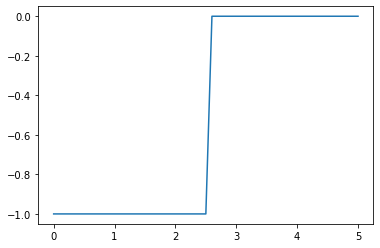

In [52]:
plt.plot(Ulist_ex,ChernNum)

In [60]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.02
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.02

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

Ulist_opt = np.linspace(0,5,16)
ChernNum_opt = np.zeros(len(Ulist_opt),dtype=float)

nshots = 8000

for nu, U in enumerate(Ulist_opt):
    Ux_opt = Xlink_opt(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)
    Uy_opt = Ylink_opt(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)
    ChernNum_opt[nu] = get_Chern(kxlst,kylst,Ux_opt,Uy_opt)

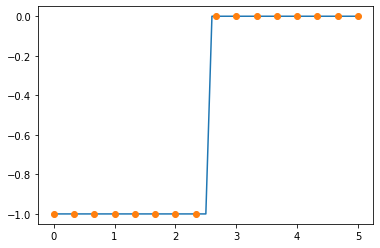

In [61]:
plt.plot(Ulist_ex,ChernNum)
plt.plot(Ulist_opt,ChernNum_opt,'o')

In [58]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.05
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.05

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

Ulist_bundle = np.linspace(2,3,4)
ChernNum_bundle = np.zeros(len(Ulist_bundle),dtype=float)

nshots = 8000

for nu, U in enumerate(Ulist_bundle):
    Ux_opt, Pstrx_list,Pcoex_list, qstatex_list, thetax_list, opx_list \
    = Xlink_proj(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)
    Uy_opt, Pstry_list,Pcoey_list, qstatey_list, thetay_list, opy_list \
    = Ylink_proj(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)
    circx, Ncirx = build_bundle(qstatex_list,thetax_list,opx_list,Pcoex_list,Pstrx_list,3)
    circy, Nciry = build_bundle(qstatey_list,thetay_list,opy_list,Pcoey_list,Pstry_list,3)
    qobjx=qiskit.transpile(circx,initial_layout=[0,1,2])
    jobx = qiskit.execute(qobjx, backend_sim,shots=nshots)
    qobjy=qiskit.transpile(circy,initial_layout=[0,1,2])
    joby = qiskit.execute(qobjy, backend_sim,shots=nshots)
    measx = obtain_bundle(jobx,Ncirx,nshots)
    Uxc = obtain_Ulink(measx,Pstrx_list,Pcoex_list)
    measy = obtain_bundle(joby,Nciry,nshots)
    Uyc = obtain_Ulink(measy,Pstry_list,Pcoey_list)
    ChernNum_bundle[nu] = get_Chern(kxlst,kylst,Uxc,Uyc)

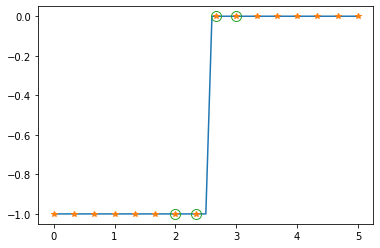

In [63]:
plt.plot(Ulist_ex,ChernNum)
plt.plot(Ulist_opt,ChernNum_opt,'*')
plt.plot(Ulist_bundle,ChernNum_bundle,'o',markerfacecolor='none',markersize=10)

In [89]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.05
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.05

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

U = Ulist_bundle[0]

Ux_opt, Pstrx_list,Pcoex_list, qstatex_list, thetax_list, opx_list \
= Xlink_proj(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)
Uy_opt, Pstry_list,Pcoey_list, qstatey_list, thetay_list, opy_list \
= Ylink_proj(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)

circx, Ncirx = build_bundle(qstatex_list,thetax_list,opx_list,Pcoex_list,Pstrx_list,3)
circy, Nciry = build_bundle(qstatey_list,thetay_list,opy_list,Pcoey_list,Pstry_list,3)

In [90]:
qobjx=qiskit.transpile(circx,initial_layout=[0,1,4])
jobx_2 = qiskit.execute(qobjx, backend2,shots=nshots)

qobjy=qiskit.transpile(circy,initial_layout=[0,1,4])
joby_2 = qiskit.execute(qobjy, backend2,shots=nshots)

In [92]:
## load old data

jobx_2 = backend2.retrieve_job('62c6e7957f065581cc8a2c40')
joby_2 = backend2.retrieve_job('62c6e8387f06559eb58a2c47')

In [96]:
measx = obtain_bundle(jobx_2,Ncirx,nshots)
Uxc_2_1 = obtain_Ulink(measx,Pstrx_list,Pcoex_list)

In [97]:
measy = obtain_bundle(joby_2,Nciry,nshots)
Uyc_2_1 = obtain_Ulink(measy,Pstry_list,Pcoey_list)

np.save('Ux_2_1',Uxc_2_1)
np.save('Uy_2_1',Uyc_2_1)

In [98]:
ChernNum_at_2_1 = get_Chern(kxlst,kylst,Uxc_2_1,Uyc_2_1)
print(ChernNum_at_2_1)

-1.0


In [100]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.05
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.05

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

U = Ulist_bundle[1]

Ux_opt, Pstrx_list,Pcoex_list, qstatex_list, thetax_list, opx_list \
= Xlink_proj(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)
Uy_opt, Pstry_list,Pcoey_list, qstatey_list, thetay_list, opy_list \
= Ylink_proj(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)

circx, Ncirx = build_bundle(qstatex_list,thetax_list,opx_list,Pcoex_list,Pstrx_list,3)
circy, Nciry = build_bundle(qstatey_list,thetay_list,opy_list,Pcoey_list,Pstry_list,3)

In [72]:
qobjx=qiskit.transpile(circx,initial_layout=[0,1,4])
jobx = qiskit.execute(qobjx, backend2,shots=nshots)

qobjy=qiskit.transpile(circy,initial_layout=[0,1,4])
joby = qiskit.execute(qobjy, backend2,shots=nshots)

In [101]:
jobx_7D3 = backend2.retrieve_job('62c6f1dcf6a6d416ef57378f')
joby_7D3 = backend2.retrieve_job('62c6f212f6a6d41ce2573791')

In [104]:
measx = obtain_bundle(jobx_7D3,Ncirx,nshots)
Uxc_7D3 = obtain_Ulink(measx,Pstrx_list,Pcoex_list)

In [105]:
measy = obtain_bundle(joby_7D3,Nciry,nshots)
Uyc_7D3 = obtain_Ulink(measy,Pstry_list,Pcoey_list)

np.save('Uxc_7D3',Uxc_7D3)
np.save('Uyc_7D3',Uyc_7D3)

In [106]:
ChernNum_at_7D3 = get_Chern(kxlst,kylst,Uxc_7D3,Uyc_7D3)
print(ChernNum_at_7D3)

-1.0000000000000002


In [107]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.05
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.05

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

U = Ulist_bundle[2]

Ux_opt, Pstrx_list,Pcoex_list, qstatex_list, thetax_list, opx_list \
= Xlink_proj(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)
Uy_opt, Pstry_list,Pcoey_list, qstatey_list, thetay_list, opy_list \
= Ylink_proj(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)

circx, Ncirx = build_bundle(qstatex_list,thetax_list,opx_list,Pcoex_list,Pstrx_list,3)
circy, Nciry = build_bundle(qstatey_list,thetay_list,opy_list,Pcoey_list,Pstry_list,3)

In [108]:
qobjx=qiskit.transpile(circx,initial_layout=[0,1,4])
jobx_8D3 = qiskit.execute(qobjx, backend2,shots=nshots)

qobjy=qiskit.transpile(circy,initial_layout=[0,1,4])
joby_8D3 = qiskit.execute(qobjy, backend2,shots=nshots)

In [109]:
measx = obtain_bundle(jobx_8D3,Ncirx,nshots)
Uxc_8D3 = obtain_Ulink(measx,Pstrx_list,Pcoex_list)

measy = obtain_bundle(joby_8D3,Nciry,nshots)
Uyc_8D3 = obtain_Ulink(measy,Pstry_list,Pcoey_list)

np.save('Uxc_8D3',Uxc_8D3)
np.save('Uyc_8D3',Uyc_8D3)

In [110]:
ChernNum_at_8D3 = get_Chern(kxlst,kylst,Uxc_8D3,Uyc_8D3)
print(ChernNum_at_8D3)

2.6504622345529306e-17


In [111]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.05
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.05

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

U = Ulist_bundle[3]

Ux_opt, Pstrx_list,Pcoex_list, qstatex_list, thetax_list, opx_list \
= Xlink_proj(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)
Uy_opt, Pstry_list,Pcoey_list, qstatey_list, thetay_list, opy_list \
= Ylink_proj(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,2.5e-1)

circx, Ncirx = build_bundle(qstatex_list,thetax_list,opx_list,Pcoex_list,Pstrx_list,3)
circy, Nciry = build_bundle(qstatey_list,thetay_list,opy_list,Pcoey_list,Pstry_list,3)

In [112]:
qobjx=qiskit.transpile(circx,initial_layout=[0,1,4])
jobx_3 = qiskit.execute(qobjx, backend2,shots=nshots)

qobjy=qiskit.transpile(circy,initial_layout=[0,1,4])
joby_3 = qiskit.execute(qobjy, backend2,shots=nshots)

In [115]:
measx = obtain_bundle(jobx_3,Ncirx,nshots)
Uxc_3 = obtain_Ulink(measx,Pstrx_list,Pcoex_list)

measy = obtain_bundle(joby_3,Nciry,nshots)
Uyc_3 = obtain_Ulink(measy,Pstry_list,Pcoey_list)

np.save('Uxc_3',Uxc_3)
np.save('Uyc_3',Uyc_3)

In [116]:
ChernNum_at_3 = get_Chern(kxlst,kylst,Uxc_3,Uyc_3)
print(ChernNum_at_3)

1.1043592643970545e-18


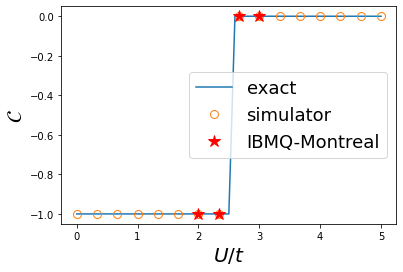

In [120]:
plt.plot(Ulist_ex,ChernNum,label='exact')
plt.plot(Ulist_opt,ChernNum_opt,'o',markerfacecolor='none',markersize=8,label='simulator')
plt.plot(Ulist_bundle,ChernNum_bundle,'*',markersize=13,label='IBMQ-Montreal',color='red')

plt.ylabel(r'$\mathcal{C}$',fontsize=20)
plt.xlabel(r'$U/t$',fontsize=20)
plt.legend(fontsize=18)

In [121]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.05
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.05

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

U = Ulist_bundle[0]

Ux_opt, Pstrx_list,Pcoex_list, qstatex_list, thetax_list, opx_list \
= Xlink_proj(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,1e-1)
Uy_opt, Pstry_list,Pcoey_list, qstatey_list, thetay_list, opy_list \
= Ylink_proj(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,1e-1)

circx, Ncirx = build_bundle(qstatex_list,thetax_list,opx_list,Pcoex_list,Pstrx_list,3)
circy, Nciry = build_bundle(qstatey_list,thetay_list,opy_list,Pcoey_list,Pstry_list,3)

In [122]:
qobjx=qiskit.transpile(circx,initial_layout=[0,1,4])
jobx_2_01 = qiskit.execute(qobjx, backend2,shots=nshots)

qobjy=qiskit.transpile(circy,initial_layout=[0,1,4])
joby_2_01 = qiskit.execute(qobjy, backend2,shots=nshots)

In [125]:
measx = obtain_bundle(jobx_2_01,Ncirx,nshots)
Uxc_2_01 = obtain_Ulink(measx,Pstrx_list,Pcoex_list)

measy = obtain_bundle(joby_2_01,Nciry,nshots)
Uyc_2_01 = obtain_Ulink(measy,Pstry_list,Pcoey_list)

np.save('Ux_2_01',Uxc_2_01)
np.save('Uy_2_01',Uyc_2_01)

In [126]:
ChernNum_at_2_t01 = get_Chern(kxlst,kylst,Uxc_2_01,Uyc_2_01)
print(ChernNum_at_2_t01)

-1.0


In [127]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.05
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.05

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

U = Ulist_bundle[1]

Ux_opt, Pstrx_list,Pcoex_list, qstatex_list, thetax_list, opx_list \
= Xlink_proj(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,1e-1)
Uy_opt, Pstry_list,Pcoey_list, qstatey_list, thetay_list, opy_list \
= Ylink_proj(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,1e-1)

circx, Ncirx = build_bundle(qstatex_list,thetax_list,opx_list,Pcoex_list,Pstrx_list,3)
circy, Nciry = build_bundle(qstatey_list,thetay_list,opy_list,Pcoey_list,Pstry_list,3)

In [128]:
qobjx=qiskit.transpile(circx,initial_layout=[0,1,4])
jobx_7D3_01 = qiskit.execute(qobjx, backend2,shots=nshots)

qobjy=qiskit.transpile(circy,initial_layout=[0,1,4])
joby_7D3_01 = qiskit.execute(qobjy, backend2,shots=nshots)

In [131]:
measx = obtain_bundle(jobx_7D3_01,Ncirx,nshots)
Uxc_7D3_01 = obtain_Ulink(measx,Pstrx_list,Pcoex_list)

measy = obtain_bundle(joby_7D3_01,Nciry,nshots)
Uyc_7D3_01 = obtain_Ulink(measy,Pstry_list,Pcoey_list)

np.save('Uxc_7D3_01',Uxc_7D3_01)
np.save('Uyc_7D3_01',Uyc_7D3_01)

In [137]:
ChernNum_at_7D3_01 = get_Chern(kxlst,kylst,Uxc_7D3_01,Uyc_7D3_01)
print(ChernNum_at_7D3_01)

-1.0


In [133]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.05
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.05

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

U = Ulist_bundle[2]

Ux_opt, Pstrx_list,Pcoex_list, qstatex_list, thetax_list, opx_list \
= Xlink_proj(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,1e-1)
Uy_opt, Pstry_list,Pcoey_list, qstatey_list, thetay_list, opy_list \
= Ylink_proj(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,1e-1)

circx, Ncirx = build_bundle(qstatex_list,thetax_list,opx_list,Pcoex_list,Pstrx_list,3)
circy, Nciry = build_bundle(qstatey_list,thetay_list,opy_list,Pcoey_list,Pstry_list,3)

In [134]:
qobjx=qiskit.transpile(circx,initial_layout=[0,1,4])
jobx_8D3_01 = qiskit.execute(qobjx, backend2,shots=nshots)

qobjy=qiskit.transpile(circy,initial_layout=[0,1,4])
joby_8D3_01 = qiskit.execute(qobjy, backend2,shots=nshots)

In [136]:
measx = obtain_bundle(jobx_8D3_01,Ncirx,nshots)
Uxc_8D3_01 = obtain_Ulink(measx,Pstrx_list,Pcoex_list)

measy = obtain_bundle(joby_8D3_01,Nciry,nshots)
Uyc_8D3_01 = obtain_Ulink(measy,Pstry_list,Pcoey_list)

np.save('Uxc_8D3_01',Uxc_8D3_01)
np.save('Uyc_8D3_01',Uyc_8D3_01)

In [138]:
ChernNum_at_8D3_01 = get_Chern(kxlst,kylst,Uxc_8D3_01,Uyc_8D3_01)
print(ChernNum_at_8D3_01)

1.6565388965955818e-17


In [139]:
t = 1
Nx = 3
Ny = 8

kxlst = np.arange(0,Nx,1)*(2*pi/3)/Nx+0.05
kylst = np.arange(0,Ny,1)*2*pi/Ny+0.05

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

U = Ulist_bundle[3]

Ux_opt, Pstrx_list,Pcoex_list, qstatex_list, thetax_list, opx_list \
= Xlink_proj(t,U,kxlst,kylst,Dkx,3,3,array_on,array_non,array_int,sgn_int,1e-1)
Uy_opt, Pstry_list,Pcoey_list, qstatey_list, thetay_list, opy_list \
= Ylink_proj(t,U,kxlst,kylst,Dky,3,3,array_on,array_non,array_int,sgn_int,1e-1)

circx, Ncirx = build_bundle(qstatex_list,thetax_list,opx_list,Pcoex_list,Pstrx_list,3)
circy, Nciry = build_bundle(qstatey_list,thetay_list,opy_list,Pcoey_list,Pstry_list,3)

In [140]:
qobjx=qiskit.transpile(circx,initial_layout=[0,1,4])
jobx_3_01 = qiskit.execute(qobjx, backend2,shots=nshots)

qobjy=qiskit.transpile(circy,initial_layout=[0,1,4])
joby_3_01 = qiskit.execute(qobjy, backend2,shots=nshots)

In [141]:
measx = obtain_bundle(jobx_3_01,Ncirx,nshots)
Uxc_3_01 = obtain_Ulink(measx,Pstrx_list,Pcoex_list)

measy = obtain_bundle(joby_3_01,Nciry,nshots)
Uyc_3_01 = obtain_Ulink(measy,Pstry_list,Pcoey_list)

np.save('Uxc_3_01',Uxc_3_01)
np.save('Uyc_3_01',Uyc_3_01)

In [142]:
ChernNum_at_3_01 = get_Chern(kxlst,kylst,Uxc_3_01,Uyc_3_01)
print(ChernNum_at_3_01)

-1.766974823035287e-17


In [156]:
for gate_i in backend2.properties().gates:
    print("{} gate on qubits {} error rate is {}{}".format(gate_i.name, gate_i.qubits, gate_i.parameters[0].value, gate_i.parameters[0].unit))

id0 gate on qubits [0] error rate is 0.0005530042031759426
id1 gate on qubits [1] error rate is 0.0007431613239033398
id2 gate on qubits [2] error rate is 0.0007999690300729785
id3 gate on qubits [3] error rate is 0.0012504609953503311
id4 gate on qubits [4] error rate is 0.0003974508691630618
id5 gate on qubits [5] error rate is 0.0006267357145789015
id6 gate on qubits [6] error rate is 0.0005021663123886342
id7 gate on qubits [7] error rate is 0.0007721104873858826
id8 gate on qubits [8] error rate is 0.004387002509508024
id9 gate on qubits [9] error rate is 0.0006026087242475339
id10 gate on qubits [10] error rate is 0.0006217288846269248
id11 gate on qubits [11] error rate is 0.0006977684302200402
id12 gate on qubits [12] error rate is 0.0015423755318629345
id13 gate on qubits [13] error rate is 0.0007604187117311383
id14 gate on qubits [14] error rate is 0.0008293795919352275
id15 gate on qubits [15] error rate is 0.0007754222618230639
id16 gate on qubits [16] error rate is 0.0010

In [168]:
backend2.properties().frequency(0)

4911094337.401199

In [165]:
print(gate_i)

In [171]:
Ux = Uxc_7D3_01
Uy = Uyc_7D3_01

Nx = len(kxlst)
Ny = len(kylst)
LF = np.zeros((len(kxlst),len(kylst)),dtype=complex)
NF = np.zeros((len(kxlst),len(kylst)),dtype=float)
for nx in range(len(kxlst)):
    for ny in range(len(kylst)):
        U1x = Ux[nx*Ny+ny]
        U2y = Uy[nx*Ny+ny]
        if ny+1==Ny:
            U1y = Ux[nx*Ny]
        else:
            U1y = Ux[nx*Ny+(ny+1)]
        if nx+1==Nx:
            U2x = Uy[ny]
        else:
            U2x = Uy[(nx+1)*Ny+ny]
        LF[nx,ny] = np.log( U1x * U2x * 1./U1y * 1./U2y)
        NF[nx,ny] = np.imag(LF[nx,ny] - (np.log(U1x) - np.log(U1y)) - (np.log(U2x) - np.log(U2y)))/(2*pi)
np.around(NF,1)

array([[ 0., -0.,  0., -0.,  0., -0.,  0.,  0.],
       [ 0., -0.,  0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0., -0., -1.,  0.]])

In [173]:
Ux = Uxc_2_01
Uy = Uyc_2_01

Nx = len(kxlst)
Ny = len(kylst)
LF = np.zeros((len(kxlst),len(kylst)),dtype=complex)
NF1 = np.zeros((len(kxlst),len(kylst)),dtype=float)
for nx in range(len(kxlst)):
    for ny in range(len(kylst)):
        U1x = Ux[nx*Ny+ny]
        U2y = Uy[nx*Ny+ny]
        if ny+1==Ny:
            U1y = Ux[nx*Ny]
        else:
            U1y = Ux[nx*Ny+(ny+1)]
        if nx+1==Nx:
            U2x = Uy[ny]
        else:
            U2x = Uy[(nx+1)*Ny+ny]
        LF[nx,ny] = np.log( U1x * U2x * 1./U1y * 1./U2y)
        NF1[nx,ny] = np.imag(LF[nx,ny] - (np.log(U1x) - np.log(U1y)) - (np.log(U2x) - np.log(U2y)))/(2*pi)
np.around(NF1,1)

array([[ 0., -0.,  0., -0., -0.,  0.,  0.,  0.],
       [-0., -0.,  0.,  0.,  0., -0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])

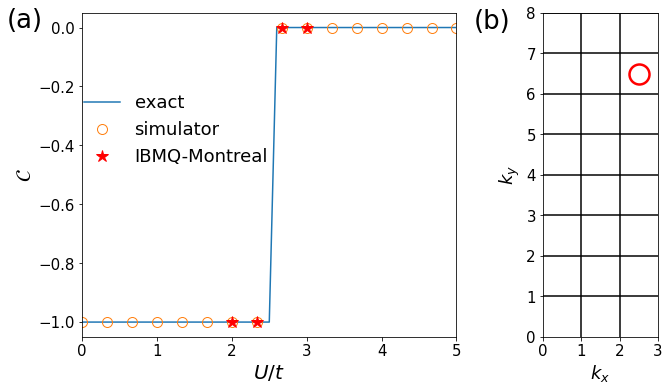

In [207]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.axis('off')

ax1 = fig.add_axes([0, 0.05, 0.65, 0.9], xlim=(0, 5), ylim=(-1.05, 0.05))
plt.setp(ax1.get_yticklabels(), fontsize=15)
plt.setp(ax1.get_xticklabels(), fontsize=15)

ax1.plot(Ulist_ex,ChernNum,label='exact')
ax1.plot(Ulist_opt,ChernNum_opt,'o',markerfacecolor='none',markersize=10,label='simulator')
ax1.plot(Ulist_bundle,ChernNum_bundle,'*',markersize=13,label='IBMQ-Montreal',color='red')

ax1.set_ylabel(r'$\mathcal{C}$',fontsize=20)
ax1.set_xlabel(r'$U/t$',fontsize=20)
ax1.legend(bbox_to_anchor=(0.54, 0.8), ncol=1, loc='upper right', frameon=False, fontsize=18)
ax1.text(-1, 0,r'(a)',fontsize=26);

ax2 = fig.add_axes([0.8, 0.05, 0.2, 0.9], xlim=(0, 3), ylim=(0, 8))
plt.setp(ax2.get_yticklabels(), fontsize=15)
plt.setp(ax2.get_xticklabels(), fontsize=15)

ax2.plot([0,3],[1,1],'k-')
ax2.plot([0,3],[2,2],'k-')
ax2.plot([0,3],[3,3],'k-')
ax2.plot([0,3],[4,4],'k-')
ax2.plot([0,3],[5,5],'k-')
ax2.plot([0,3],[6,6],'k-')
ax2.plot([0,3],[7,7],'k-')
ax2.plot([0,3],[8,8],'k-')
ax2.plot([1,1],[0,8],'k-')
ax2.plot([2,2],[0,8],'k-')
ax2.plot([2.5],[6.5],'ro',markerfacecolor='None',markersize=20,markeredgewidth=2.5)
ax2.set_ylabel(r'$k_y$',fontsize=18)
ax2.set_xlabel(r'$k_x$',fontsize=18)

ax2.text(-1.8, 7.6,r'(b)',fontsize=26);

plt.savefig('Fig7n.pdf', bbox_inches='tight')